In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from ucimlrepo import fetch_ucirepo

# 1. 导入数据
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = bank_marketing.data.targets['y']

# 2. 处理缺失值
X = X.copy()
X['job'] = X['job'].fillna('unknown')
X['education'] = X['education'].fillna('unknown')
X['contact'] = X['contact'].fillna('unknown')
X = X.drop(columns=['poutcome'])  # 删除缺失值过多的列

# 3. 处理右偏连续变量
continuous_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
for col in continuous_cols:
    if col in ['balance', 'duration', 'campaign', 'pdays', 'previous']:
        if (X[col] <= 0).any():
            print(f"{col} 包含非正值，应用偏移对数变换")
            X[col] = np.log1p(X[col] - X[col].min() + 1)
        else:
            X[col] = np.log1p(X[col])

# 4. 识别数值和类别特征
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# 5. 预处理管道（数值标准化 + 类别独热编码）
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# 6. 应用预处理
X_processed = preprocessor.fit_transform(X)

# 7. 获取特征名称
feature_names = (numerical_cols.tolist() + 
                 preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist())

# 8. 保存处理后的数据
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
X_processed_df.to_csv('processed_bank_data.csv', index=False)

# 保存原始数据以便后续分析
X.to_csv('raw_bank_data.csv', index=False)

balance 包含非正值，应用偏移对数变换
duration 包含非正值，应用偏移对数变换
pdays 包含非正值，应用偏移对数变换
previous 包含非正值，应用偏移对数变换


/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_38528/580970272.py:24: UserWarning: Glyph 24815 (\N{CJK UNIFIED IDEOGRAPH-60EF}) missing from current font.
  plt.savefig('elbow_plot_kmeans.png')
/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_38528/580970272.py:24: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  plt.savefig('elbow_plot_kmeans.png')
/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_38528/580970272.py:24: UserWarning: Glyph 32920 (\N{CJK UNIFIED IDEOGRAPH-8098}) missing from current font.
  plt.savefig('elbow_plot_kmeans.png')
/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_38528/580970272.py:24: UserWarning: Glyph 37096 (\N{CJK UNIFIED IDEOGRAPH-90E8}) missing from current font.
  plt.savefig('elbow_plot_kmeans.png')
/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_38528/580970272.py:24: UserWarning: Glyph 27861 (\N{CJK UNIFIED IDEOGRAPH-6CD5}) missing from current font.
  plt.sav

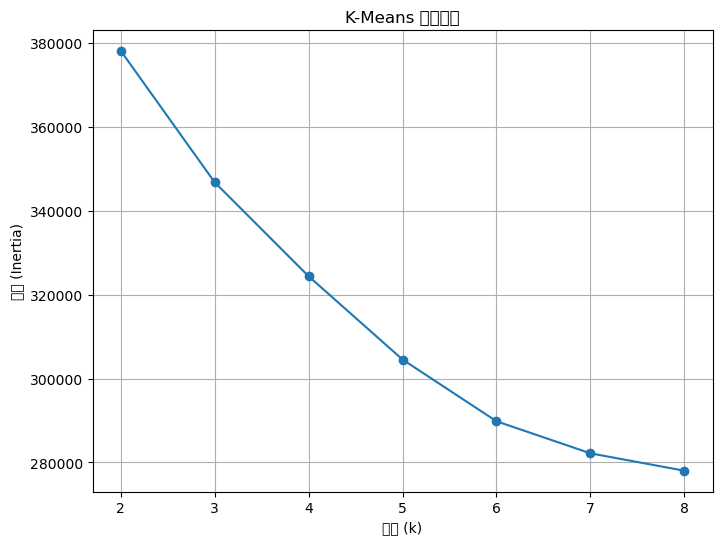

K-Means 簇特征概览:
                age   balance  day_of_week  duration  campaign     pdays  \
Cluster                                                                   
0        35.448371  9.068983    23.450143  5.350899  1.009169  0.700041   
1        40.571830  9.116304    14.207196  5.229194  1.023561  5.302731   
2        34.812205  9.059311     8.197146  5.325847  1.022495  0.697516   
3        43.568918  9.745321    16.156970  5.264448  1.100325  1.095731   
4        54.026812  9.092362    14.056397  5.236756  1.041857  0.728064   
5        41.312245  9.077226    20.792785  4.417332  2.073137  0.711216   

         previous  
Cluster            
0        0.695111  
1        1.531663  
2        0.694447  
3        0.751065  
4        0.697573  
5        0.695214  
K-Means (k=6) 轮廓系数: 0.1102


In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

# 加载处理后的数据
X_processed = pd.read_csv('processed_bank_data.csv')

# 肘部法则选择 k
inertia = []
k_range = range(2, 9)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)

# 绘制肘部图
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('簇数 (k)')
plt.ylabel('惯性 (Inertia)')
plt.title('K-Means 肘部法则')
plt.grid(True)
plt.savefig('elbow_plot_kmeans.png')
plt.show()

# 选择最佳 k（假设为 4，可根据肘部图调整）
best_k = 6
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X_processed)

# 添加簇标签到原始数据
X_raw = pd.read_csv('raw_bank_data.csv')
X_raw['Cluster'] = clusters

# 分析簇特征
cluster_summary = X_raw.groupby('Cluster').mean(numeric_only=True)
print("K-Means 簇特征概览:\n", cluster_summary)

# 计算轮廓系数
score = silhouette_score(X_processed, clusters)
print(f"K-Means (k={best_k}) 轮廓系数: {score:.4f}")

/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_38528/1735817038.py:16: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from current font.
  plt.savefig('dendrogram_hierarchical.png')
/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_38528/1735817038.py:16: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  plt.savefig('dendrogram_hierarchical.png')
/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_38528/1735817038.py:16: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from current font.
  plt.savefig('dendrogram_hierarchical.png')
/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_38528/1735817038.py:16: UserWarning: Glyph 31163 (\N{CJK UNIFIED IDEOGRAPH-79BB}) missing from current font.
  plt.savefig('dendrogram_hierarchical.png')
/var/folders/qv/vr5nbq_n1yg_gzj82zd6psl80000gn/T/ipykernel_38528/1735817038.py:16: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing

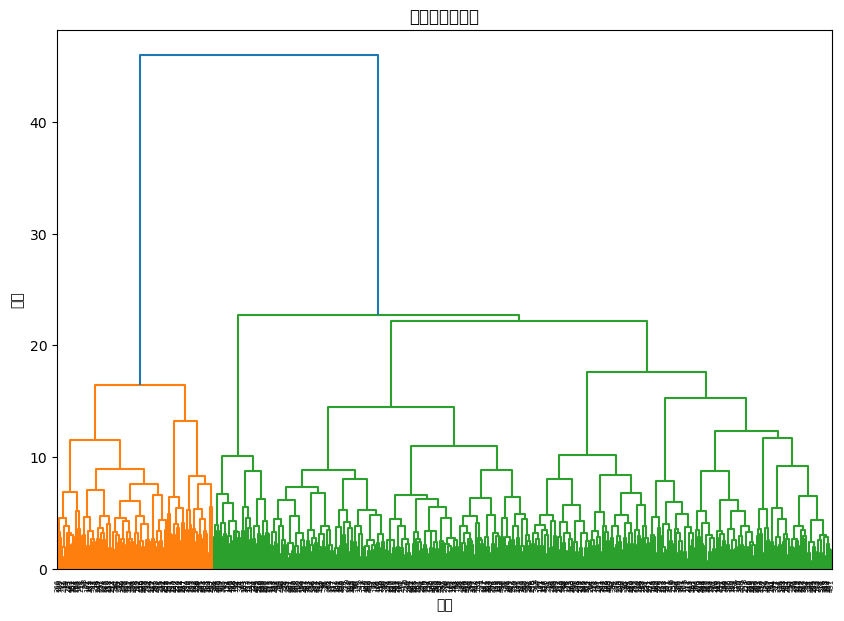

层次聚类簇特征概览:
                age   balance  day_of_week  duration  campaign     pdays  \
Cluster                                                                   
0        35.559322  9.051874    19.457627  4.664526  1.490149  0.693147   
1        41.220238  9.054018    10.214286  5.597595  1.005133  0.693147   
2        38.464789  9.087841    12.802817  5.281367  0.963359  5.377529   
3        43.233333  9.371905    14.466667  5.006822  1.245026  5.350237   
4        50.500000  9.094760    21.381579  5.416922  1.275025  0.693147   
5        42.702703  9.633012    16.189189  4.967304  1.031182  0.693147   

         previous  
Cluster            
0        0.693147  
1        0.693147  
2        1.368870  
3        2.093261  
4        0.693147  
5        0.693147  
层次聚类 (k=6) 轮廓系数: 0.0872


In [11]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import pandas as pd

# 加载处理后的数据（抽样 500 条以降低计算成本）
X_processed_sample = pd.read_csv('processed_bank_data.csv').sample(n=500, random_state=42)

# 生成树状图
Z = linkage(X_processed_sample, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('层次聚类树状图')
plt.xlabel('样本')
plt.ylabel('距离')
plt.savefig('dendrogram_hierarchical.png')
plt.show()

# 选择簇数（假设为 4，可根据树状图调整）
best_k = 6
hierarchical = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
clusters = hierarchical.fit_predict(X_processed_sample)

# 添加簇标签到原始数据
X_raw_sample = pd.read_csv('raw_bank_data.csv').iloc[X_processed_sample.index]
X_raw_sample['Cluster'] = clusters

# 分析簇特征
cluster_summary = X_raw_sample.groupby('Cluster').mean(numeric_only=True)
print("层次聚类簇特征概览:\n", cluster_summary)

# 计算轮廓系数
score = silhouette_score(X_processed_sample, clusters)
print(f"层次聚类 (k={best_k}) 轮廓系数: {score:.4f}")

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import pandas as pd

# 加载处理后的数据（抽样 500 条以降低计算成本）
X_processed_sample = pd.read_csv('processed_bank_data.csv').sample(n=500, random_state=42)

# DBSCAN 聚类
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_processed_sample)

# 添加簇标签到原始数据
X_raw_sample = pd.read_csv('raw_bank_data.csv').iloc[X_processed_sample.index]
X_raw_sample['Cluster'] = clusters

# 分析簇特征
cluster_summary = X_raw_sample.groupby('Cluster').mean(numeric_only=True)
print("DBSCAN 簇特征概览:\n", cluster_summary)

# 计算轮廓系数（仅对非噪声点）
if len(set(clusters)) > 1:
    score = silhouette_score(X_processed_sample[clusters != -1], clusters[clusters != -1])
    print(f"DBSCAN 轮廓系数: {score:.4f}")
else:
    print("DBSCAN 未识别出多个簇")

DBSCAN 簇特征概览:
             age   balance  day_of_week  duration  campaign     pdays  previous
Cluster                                                                       
-1       41.134  9.126426       15.158  5.222936   1.17101  1.637755  0.873107
DBSCAN 未识别出多个簇


In [10]:
import pandas as pd

# 加载原始数据和目标变量
X_raw = pd.read_csv('raw_bank_data.csv')
y = pd.read_csv('bank_marketing.csv')['y']  # 假设原始数据集文件名为 bank_marketing.csv

# 为每种方法添加订阅率分析（以 K-Means 为例）
X_raw['y'] = y
subscription_rate = X_raw.groupby('Cluster')['y'].apply(lambda x: (x == 'yes').mean())
print("K-Means 各簇订阅率:\n", subscription_rate)

FileNotFoundError: [Errno 2] No such file or directory: 'bank_marketing.csv'

In [13]:
import pandas as pd
import gower  # pip install gower
from sklearn.metrics import silhouette_score

# 1. 加载已聚类数据（假设列名包含 'Cluster'）
clustered_data = pd.read_csv('kprototypes_clustered_data.csv')

# 2. 提取特征列（去掉 'Cluster' 列）
X = clustered_data.drop('Cluster', axis=1)

# 3. 计算 Gower 距离矩阵（适用于混合数据）
distance_matrix = gower.gower_matrix(X)

# 4. 计算轮廓系数（基于 Gower 距离）
silhouette_avg = silhouette_score(distance_matrix, clustered_data['Cluster'], metric="precomputed")
print(f"Silhouette Score (Gower Distance): {silhouette_avg:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: 'kprototypes_clustered_data.csv'